In [10]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
from sklearn.metrics import classification_report

import pickle

## Загружаем исходные данные

In [5]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [217]:
# сохраняем разметку в отдельную переменную
train_target = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [218]:
train_img.shape, test_img.shape

((42000, 28, 28), (28000, 28, 28))

## Lets see what is it

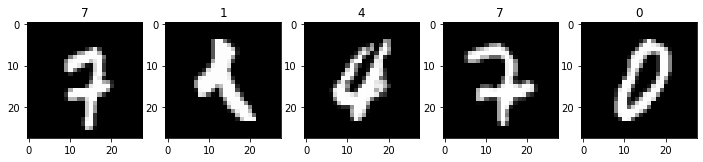

In [5]:
fig = plt.figure(figsize=(12,7))
check = np.random.randint(0,len(train_label),size=5)

for i,j in enumerate(train_img[check]):
    ax = fig.add_subplot(151 + i)
    plt.imshow(j, cmap='gray')
    plt.title('%d' %train_label[check][i])

Не буду показывать что делал с изображеиями, покажу сразу результат:

## сделаем функции для обработки изображения

In [6]:
def make_sobel(img):
    ''' 
        ВЕРНЕТ ИЗОБРАЖЕНИЕ ОБРАБОТАННОЕ ФИЛЬТРАМИ СОБЕЛЯ
            ПО ПОРЯДКУ X, Y, (X+Y)
    '''
    
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])

    sobel_y = np.array([[-1, -2, -1],
                        [ 0,  0,  0],
                        [ 1,  2,  1]])

    sobel_img_x = cv2.filter2D(img, -1, sobel_x)
    sobel_img_x_normed = np.abs(sobel_img_x)/np.max(np.abs(sobel_img_x))

    sobel_img_y = cv2.filter2D(img, -1, sobel_y)
    sobel_img_y_normed = np.abs(sobel_img_y)/np.max(np.abs(sobel_img_y))
   
    sobel_img = (sobel_img_x_normed**2 + sobel_img_y_normed**2 )**.5

    return sobel_img_x_normed, sobel_img_y_normed, sobel_img

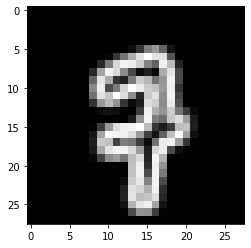

In [7]:
# sobel
plt.imshow( make_sobel( train_img[check][0])[2] , cmap='gray')

In [8]:
def non_max_suppress(img, threshold = 85):
    '''
        ОТСЕЧЕТ ОТ ИЗОБРАЖЕНИЯ ВСЁ, ЧТО НИЖЕ ПОРОГА (THRESHOLD)
            THRESHOLD УКАЗЫВАТЬ В %
    '''
    
    threshold = threshold * (np.max(img)-np.min(img)) /100
        
    return np.where( img > threshold , img, np.zeros_like(img))


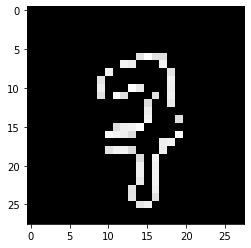

In [9]:
a = make_sobel( train_img[check][0])[2]
a = non_max_suppress(a, threshold = 85)
plt.imshow( a , cmap='gray')

In [10]:
def sharpen(img):    
#         sharpen_kernel = np.array([
#           [0, 0, 0],
#           [0, 2, 0],
#           [0, 0, 0]
#         ])
#         return cv2.filter2D( img , -1, sharpen_kernel)
    return np.where( img > 0 , np.ones_like(img), np.zeros_like(img)) 

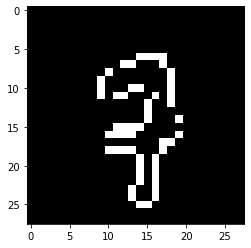

In [11]:
plt.imshow( sharpen(a) , cmap='gray')

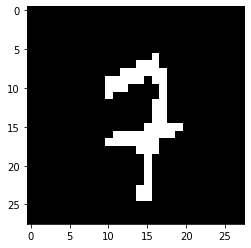

In [12]:
plt.imshow( sharpen(non_max_suppress(  train_img[check][0]) ) , cmap='gray')

## Как будет построен процесс:

1. из каждого треин экземпляра будет делаться два изображения (см.выше)
1. оба изображения конкатенируются по-горизонтали,
1. проводится svd и вытягивается трансфомированный вектор.
1. обучается весь трансформированный датасет на SVM 

In [14]:
def img_processing(img):
    # sobel
    # non_max_suppress
    # sharpen
    a = make_sobel( img )[2]
    a = non_max_suppress(a)
    a = sharpen(a)
    # non_max_suppress
    # sharpen
    b = non_max_suppress(img)
    b = sharpen(b)
    
    return np.concatenate((a,b),axis=1)

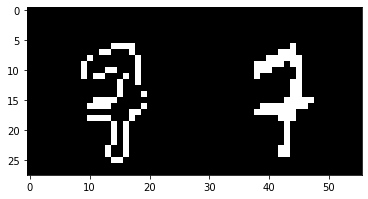

In [126]:
c = img_processing( train_img[check][0] )
plt.imshow( c , cmap='gray')

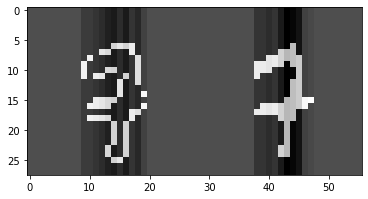

In [128]:
c_mean = c.mean(axis=0)
c -= c_mean
plt.imshow( c , cmap='gray')

In [129]:
cov = np.dot(c.T, c) / c.shape[0]

In [130]:
U, S, V = np.linalg.svd(cov)
# U - поворот (новый базис) 
# S - растяжение
# V -  поворот (новый базис) собственные вектора

# для симметричной матрицы повороты равны между собой : U.T = V
U.shape, S.shape, V.shape

((56, 56), (56,), (56, 56))

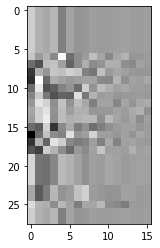

In [131]:
с_reduced = np.dot(c, U[:, :16])
plt.imshow( с_reduced , cmap='gray')

Четко вырисовываются границы цифры 7. А вот на методе sklearn PCA такого нет(смотри ниже).

Это связано с тем, что исходная картинка имеет размерность 28х56 и sklearn поворачивает картинку в сторону мЕньшей размерности и отом проводит SVD преобразования. 

__Вывод:__

Если мы буде придерживаться тактики sklearn PCA - то никакого смысла не будет, потому что картинка становится не читаемая. 

Если же использовать numpy и здравый смысл, то получаемая картика вполне пригдна для идентификации что там за цифра - нам же это главное.

In [132]:
from sklearn.decomposition import PCA

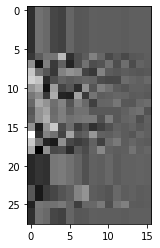

In [133]:
pca = PCA(n_components=16)
c_red = pca.fit_transform(c)
plt.imshow( c_red , cmap='gray')

In [134]:
# Далее вытягиваем все в длинный вектор
с_reduced_flatten = с_reduced.ravel()
с_reduced_flatten.shape

(448,)

мы из большого пространства 28х56 превратили в 28х16, что даёт примерно __80% экономии места__( зависит от количества используемых собственных векторов). 

Данный пример показал, как изображение можно уменьшить в размерах. Но поставленная задача, требует найти такие различия между изображениями, чтобы логит(или другой классификатор) смог отличить дла изображения(смотри далее). 

Выполним весь пайплайн и проверим результат логита:

1. препроцессинг изображения
1. pca изображения
1. вытягивание изображения в один вектор. 
1. для того чтобы получилась матрица всех вытянутых изображений, нужно чтобы вытянутые изображения имели одинаковый размер. Это значит нужно обозначить количество компонент. Выберем количество компонент = 16
1. трайн тест сплит
1. обучение логита и проверка на тесте.


In [167]:
def make_svd_flatten(img, eigenvectors_n_comp = 16 ):
    img = np.float32( img )

    img_mean = img.mean(axis=0)
    img -= img_mean

    cov = np.dot(img.T, img) / img.shape[0]
    
    U, S, V = np.linalg.svd(cov)

    img_reduced = np.dot(img, U[:, :eigenvectors_n_comp]) 
        
    return img_reduced.ravel()


In [168]:
def pipe(dataset):
    result = np.zeros_like(с_reduced_flatten , np.float32) 
    
    for img in tqdm(dataset):
        # img_processing
        # svd + flatten
        # concat
        c = img_processing(img)
        img_transformed = make_svd_flatten(c, eigenvectors_n_comp = 16 )
        result = np.concatenate((result,img_transformed),axis = 0)
    
    return result[с_reduced_flatten.shape[0]:].reshape(dataset.shape[0],-1)

In [169]:
X_train = pipe(train_img)

100%|████████████████████████████████████| 42000/42000 [15:20<00:00, 45.65it/s]


In [180]:
# save
with open('./preprocessed/X_train.pickle' , 'wb') as f:
    pickle.dump(X_train,f)
f.close() 

with open('./preprocessed/train_target.pickle' , 'wb') as f:
    pickle.dump(train_target,f)
f.close()


In [179]:
# train_test_split

X_train_small , X_val, y_train_small, y_val = train_test_split(X_train, train_target, test_size=0.3, random_state=255)

In [181]:
# logit
logit = LogisticRegression(penalty='elasticnet',
    solver='saga',
    max_iter=200,
    multi_class='multinomial',
    n_jobs=-1,
    l1_ratio=0.1)

In [182]:
logit.fit(X_train_small, y_train_small )
y_pred = logit.predict(X_val)

logit.score(X_val,y_val)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.46111111111111114

In [183]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.43      0.45      0.44      1247
         1.0       0.50      0.59      0.54      1372
         2.0       0.52      0.51      0.52      1291
         3.0       0.46      0.54      0.50      1287
         4.0       0.45      0.51      0.48      1210
         5.0       0.28      0.18      0.22      1150
         6.0       0.57      0.58      0.58      1245
         7.0       0.56      0.55      0.55      1363
         8.0       0.32      0.25      0.28      1187
         9.0       0.40      0.40      0.40      1248

    accuracy                           0.46     12600
   macro avg       0.45      0.46      0.45     12600
weighted avg       0.45      0.46      0.45     12600



Результат не удовлетворительный = 45%. Будем действовать по-другому..

## Для классификтора нужны отличия. 

Для логита нужно, найти такие отличия для картинок( матриц или вытянутых векторов), чтобы можно было однознчно сказать, что тут изображено "7" а не "2". 

Нужно собрать все изображения вместе, отбросить общее и оставить только отличия.

Сначала потренируемся на датасете из 5000 экземпляров, а потом выполним пайплайн для всего датасета


In [135]:
# 5000 экземпляров
choice = np.random.choice(train_img.shape[0], 5000)
c = [img_processing( i ) for i in train_img[choice]]

In [136]:
c = np.array(c,dtype=np.float32)
c.shape

(5000, 28, 56)

In [141]:
# вытянем нормируем и построим матрицу ковариаций
c_flatten = c.reshape((c.shape[0],-1)).astype(np.float32)

c_flatten_mean = c_flatten.mean(axis = 0 )
c_flatten -= c_flatten_mean

cov = np.dot(c_flatten.T, c_flatten) / c_flatten.shape[0]
cov.shape

(1568, 1568)

Необходимо 161 компонент, для сохранения 70% дисперсии


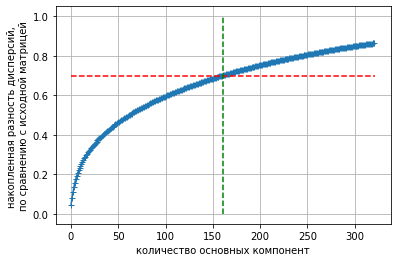

In [79]:
# SVD
U, S, V = np.linalg.svd(cov)


S_cumsum = np.cumsum(S) / np.sum(S)
eigenvectors_thershold = .7

n_comp = np.argmax(np.where(S_cumsum > eigenvectors_thershold, 1, 0)) 

plt.plot(S_cumsum[:n_comp*2], '+-')
plt.grid()
plt.plot([0,n_comp*2],[eigenvectors_thershold]*2,'r--');
plt.plot( [n_comp]*2, [0,1], 'g--')
plt.xlabel('количество основных компонент')
plt.ylabel('накопленная разность дисперсий, \nпо сравнению с исходной матрицей');
print(f'Необходимо {n_comp} компонент, для сохранения 70% дисперсии')

Выходит, что нужно использовать 161 основных компонент для сохранения 70% дисперсии исходного изображения.

Для логита нужно, найти такие отличия для картинок( матриц или вытянутых векторов), чтобы можно было однознчно сказать, что тут изображено "7" а не "2". Как это сделать? 

Нужно собрать все изображения вместе, отбросить общее и оставить только отличия. 

Отличия - это проекция исходной матрицы картинок на базис из собственных векторов, вот они:

In [156]:
с_reduced = np.dot(c_flatten, U[:, :360])
с_reduced.shape

(5000, 360)

Но как оказалось позже - проекция исходной матрицы на базис собственных векторов, очень плохо предсказывает для тестовой выборки.
 
Поэтому придется восстанавливать проекцию на обратную поворотную матрицу и скармливаем Support Vector Classificator  


## трансформируем датасет и обучем логит

Сделаем пайплайн для всего процесса:

- img preprocessing
- flatten + covariation matrix
- SVD + n_comp 
- train_test_split
- SVC

In [184]:
X_train_img_preprocessed = np.array([img_processing( i ) for i in tqdm(train_img) ], dtype=np.float32)

with open('./preprocessed/X_train_img_preprocessed.pickle' , 'wb') as f:
    pickle.dump(X_train_img_preprocessed,f)
f.close() 

X_train_img_preprocessed.shape

100%|██████████████████████████████████| 42000/42000 [00:12<00:00, 3297.99it/s]


(42000, 28, 56)

In [55]:
with open('./preprocessed/X_train_img_preprocessed.pickle' , 'rb') as f:
    X_train_img_preprocessed = pickle.load(f)
f.close()

with open('./preprocessed/train_target.pickle' , 'rb') as f:
    train_target = pickle.load(f)
f.close()

In [56]:
# вытянем нормируем и построим матрицу ковариаций
X_flatten = X_train_img_preprocessed.reshape( (X_train_img_preprocessed.shape[0],-1) ).astype(np.float32)

X_flatten_mean = X_flatten.mean(axis = 0 )
X_flatten -= X_flatten_mean

cov = np.dot(X_flatten.T, X_flatten) / X_flatten.shape[0]
cov.shape

(1568, 1568)

Необходимо 385 компонент, для сохранения 90% дисперсии


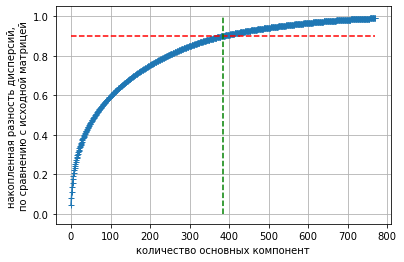

In [57]:
# SVD
U, S, V = np.linalg.svd(cov)


S_cumsum = np.cumsum(S) / np.sum(S)
eigenvectors_thershold = .9

n_comp = np.argmax(np.where(S_cumsum > eigenvectors_thershold, 1, 0)) 

plt.plot(S_cumsum[:n_comp*2], '+-')
plt.grid()
plt.plot([0,n_comp*2],[eigenvectors_thershold]*2,'r--');
plt.plot( [n_comp]*2, [0,1], 'g--')
plt.xlabel('количество основных компонент')
plt.ylabel('накопленная разность дисперсий, \nпо сравнению с исходной матрицей');
print(f'Необходимо {n_comp} компонент, для сохранения 90% дисперсии')

Необходимо 385 компонент. Но для робастности модели на тестовых данных возьем сохранение 70% дисперсии = 150 компонент. Сохраняем их:

In [58]:
X_reduced = np.dot(X_flatten, U[:, :150])
X_reduced.shape

(42000, 150)

Восстанавливаем обратной поворотной матрицей: 

In [80]:
X_restored = np.dot(X_reduced, U[:,:150].T)

Разбиваем:

In [60]:
X_train_small, X_val, y_train_small, y_val = train_test_split(
    X_restored, train_target, test_size=0.3, random_state=255)

In [35]:
from sklearn.svm import SVC

In [61]:
clf = SVC(kernel='rbf', decision_function_shape = 'ovo')
clf.fit(X_train_small, y_train_small)
y_pred = clf.predict(X_val)

print('SVM_score = ',clf.score(X_val,y_val) )

SVM_score =  0.9562698412698413


In [62]:
print( classification_report(y_val, y_pred) )

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      1247
         1.0       0.97      0.98      0.98      1372
         2.0       0.96      0.95      0.95      1291
         3.0       0.95      0.94      0.94      1287
         4.0       0.94      0.97      0.96      1210
         5.0       0.93      0.94      0.94      1150
         6.0       0.97      0.97      0.97      1245
         7.0       0.96      0.94      0.95      1363
         8.0       0.96      0.94      0.95      1187
         9.0       0.95      0.93      0.94      1248

    accuracy                           0.96     12600
   macro avg       0.96      0.96      0.96     12600
weighted avg       0.96      0.96      0.96     12600



## Визуализируем предсказания

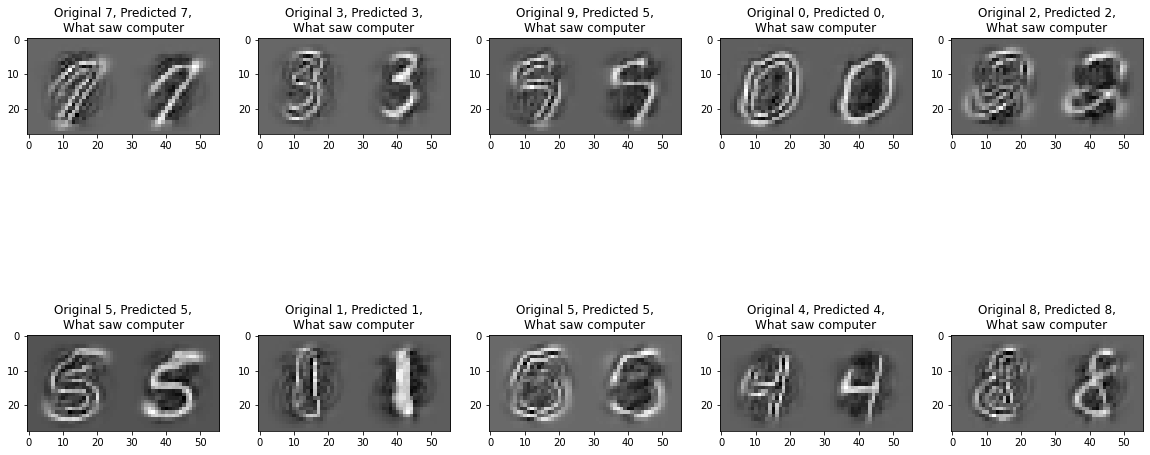

In [63]:
fig = plt.figure(figsize=(20, 10))

for i, img in enumerate(X_val[0:10], 0):
    
    ax = fig.add_subplot(2, 5, i+1)
    
    plt.imshow(img.reshape(28,-1), cmap='gray');
    plt.title('Original %d, Predicted %d,\nWhat saw computer' % (y_val[i], y_pred[i]) );
 

## трансформируем датасет для тест

In [201]:
X_test_img_preprocessed = np.array([ img_processing( i ) for i in tqdm( test_img) ], dtype=np.float32)

with open('./preprocessed/X_test_img_preprocessed.pickle' , 'wb') as f:
    pickle.dump(X_test_img_preprocessed,f)
f.close() 

X_test_img_preprocessed.shape

100%|██████████████████████████████████| 28000/28000 [00:07<00:00, 3534.46it/s]


(28000, 28, 56)

In [64]:
with open('./preprocessed/X_test_img_preprocessed.pickle' , 'rb') as f:
    X_test_img_preprocessed = pickle.load(f)
f.close()

In [82]:
# вытянем нормируем и построим матрицу ковариаций
X_flatten_test = X_test_img_preprocessed.reshape( (X_test_img_preprocessed.shape[0],-1) ).astype(np.float32)

X_flatten_test_mean = X_flatten_test.mean(axis = 0 )
X_flatten_test -= X_flatten_test_mean

cov_test = np.dot( X_flatten_test.T, X_flatten_test) / X_flatten_test.shape[0]
cov_test.shape

(1568, 1568)

In [83]:
# SVD
U_test, S_test, V_test = np.linalg.svd(cov_test)

Так как для обучения SVM мы использовали 150 компонент, то и для предикта нужно стролько же параметров (иначе будет ошибка). Применяем:

In [84]:
X_reduced_test = np.dot(X_flatten_test, U_test[:, :150])
X_reduced_test.shape

(28000, 150)

Восстанавливаем обратной поворотной матрицей:

In [90]:
X_restored_test = np.dot(X_reduced_test, U_test[:,:150].T)
X_restored_test.shape

(28000, 1568)

In [69]:
y_pred_test = clf.predict(X_restored_test)
y_pred_test_int = y_pred_test.astype(int)

## Готовим файл для отправки

In [76]:
with open('submit_3.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(y_pred_test_int, 1):
        dst.write('%s,%s\n' % (i, p))

## Визуализируем предсказания тестовой выборки:

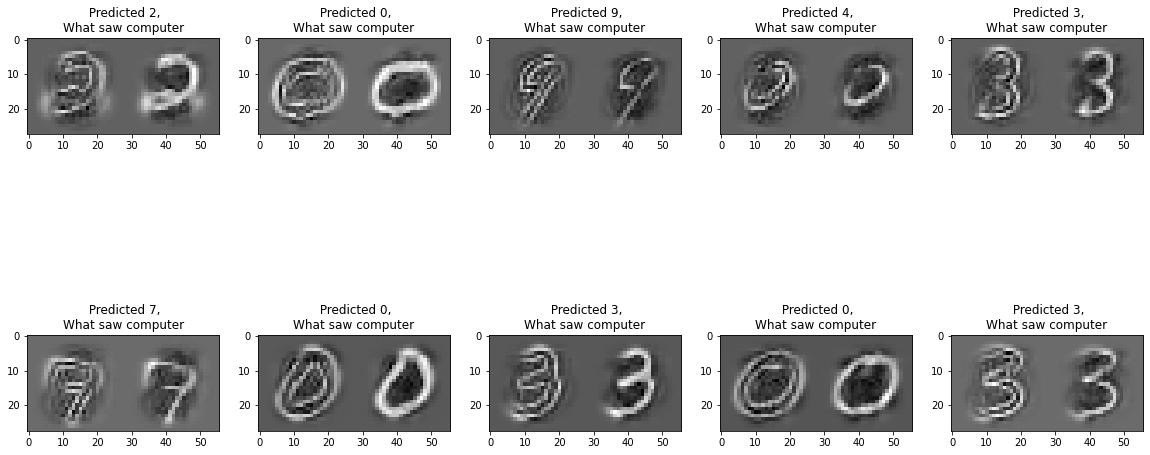

In [74]:
fig = plt.figure(figsize=(20, 10))

for i, img in enumerate(X_restored_test[0:10], 0):
    
    ax = fig.add_subplot(2, 5, i+1)
    
    plt.imshow(img.reshape(28,-1), cmap='gray');
    plt.title(' Predicted %d,\nWhat saw computer' % ( y_pred_test[i]) );
 

Для изображений c 30 по 40:

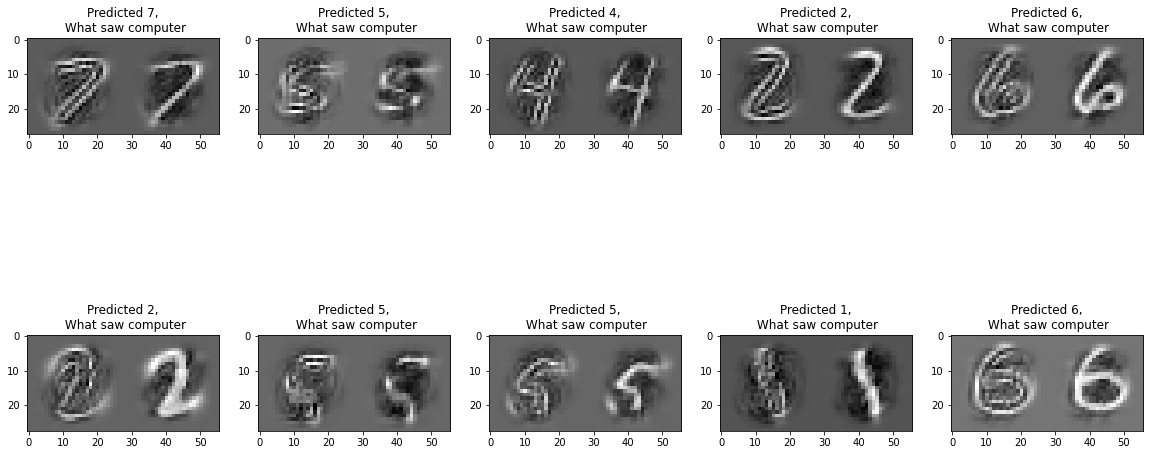

In [91]:
fig = plt.figure(figsize=(20, 10))

for i, img in enumerate(X_restored_test[30:40], 0):
    
    ax = fig.add_subplot(2, 5, i+1)
    
    plt.imshow(img.reshape(28,-1), cmap='gray');
    plt.title('Predicted %d,\n What saw computer' % (y_pred_test[30+ i]) );
 

__Что было сделано:__
1. img_processing:
    - правое изображение:
        - sobel
        - non_max_suppress
        - sharpen
    - левое изображение:
        - non_max_suppress
        - sharpen
    - concat изображений
1. flatten 
1. covariation matrix
1. SVD -> проекция на 150 первых собственных векторов и обратная поворотная матрица 150 первых собственных векторов 
1. train_test_split
1. SVC

__Результат:__
- на validation __96%__
- на test kaggle __95.3%__

__Что еще можно было сделать:__
- выполнить аугментацию:
    - поворот sklearn.transform.rotate()
    - сдвиг sklearn.transform.AffineTransform() -> sklearn.transform.warp()
- добавить маску (например круг - края не использутся для детекции)